In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *

In [3]:
with open('./state.pkl', 'rb') as f:
    my_state = pickle.load(f)

In [4]:
class MyModel():
    def __init__(self, dt_seconds=1800, nx=64, ny=32, nz=10, state=None,
                 input_fields_to_store=input_vars,
                 output_fields_to_store=output_vars,
                 input_save_fn=None,
                 output_save_fn=None,
                 save_interval=6,
                 convection=None,
                 extra_components=[],
                 nophys=False
                ):
        climt.set_constants_from_dict({
            'stellar_irradiance': {'value': 200, 'units': 'W m^-2'}})

        self.model_time_step = timedelta(seconds=dt_seconds)
        self.step_counter = 0
        self.save_interval = save_interval

        # Create components
        if convection is None: convection = MyEmanuelConvection()
        simple_physics = TimeDifferencingWrapper(climt.SimplePhysics())

        radiation = climt.GrayLongwaveRadiation()
        
        components = [
            simple_physics, radiation, convection
        ] + extra_components
        if nophys: components = None
        self.dycore = climt.GFSDynamicalCore(
            components, number_of_damped_levels=2
        )
        grid = climt.get_grid(nx=nx, ny=ny, nz=nz)
    
        if state is None:
            self.create_initial_state(grid)
        else:
            self.state = state
        
        self.state_history = [self.state]
        self.diag_history = []
        
        if not input_save_fn is None:
            self.input_netcdf_monitor = NetCDFMonitor(
                input_save_fn,
                write_on_store=True,
                store_names=input_fields_to_store
            )
        if not output_save_fn is None:
            self.output_netcdf_monitor = NetCDFMonitor(
                output_save_fn,
                write_on_store=True,
                store_names=output_fields_to_store
            )
        
    def create_initial_state(self, grid):
        # Create model state
        self.state = climt.get_default_state([self.dycore], grid_state=grid)

        # Set initial/boundary conditions
        latitudes = self.state['latitude'].values
        longitudes = self.state['longitude'].values
        surface_shape = latitudes.shape

        temperature_equator = 300
        temperature_pole = 240

        temperature_profile = temperature_equator - (
            (temperature_equator - temperature_pole)*(
                np.sin(np.radians(latitudes))**2))

        self.state['surface_temperature'] = DataArray(
            temperature_profile*np.ones(surface_shape),
            dims=['lat', 'lon'], attrs={'units': 'degK'})
        self.state['eastward_wind'].values[:] = np.random.randn(
            *self.state['eastward_wind'].shape)
        
    def step(self):
        self.diag, self.state = self.dycore(self.state, self.model_time_step)
        self.state.update(self.diag)
        self.state['time'] += self.model_time_step
        if hasattr(self, 'input_save_fn'):
            if self.step_counter % self.save_interval == 0:
                self.input_netcdf_monitor.store(self.state)
        if hasattr(self, 'output_save_fn'):
            if (self.step_counter - 1) % self.save_interval == 0:
                self.output_netcdf_monitor.store(self.state)
        self.step_counter += 1
    
    def iterate(self, steps, noprog=False):
        for i in tqdm(range(steps), disable=noprog):
            self.step()

In [134]:
model1 = MyModel(state=my_state)

In [135]:
model1.iterate(48)

In [137]:
state2 = model1.state

In [138]:
state2['time'] = my_state['time']

In [7]:
state3 = model1.state

## Forcer

In [8]:
class Forcer(TendencyComponent):
    diagnostic_properties = {
        'air_temperature_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK s^-1',
        },
        'specific_humidity_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg s^-1',
        },
        'eastward_wind_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-2',
        },
        'northward_wind_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-2',
        }
    }
    tendency_properties = {
        'air_temperature': {
            'units': 'degK s^-1',
        },
        'specific_humidity': {
            'units': 'kg/kg s^-1',
        },
        'eastward_wind': {
            'units': 'm s^-2',
        },
        'northward_wind': {
            'units': 'm s^-2',
        }
    }
    input_properties = {
        'air_temperature': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK',
        },
        'specific_humidity': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg',
        },
        'eastward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        },
        'northward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        }
    }
    def __init__(self, **kwargs):
        self.tends = None
        super().__init__(**kwargs)
        
    @ensure_contiguous_state
    def array_call(self, raw_state):
        
        tendencies = initialize_numpy_arrays_with_properties(
            self.tendency_properties, raw_state, self.input_properties
        )
        diagnostics = initialize_numpy_arrays_with_properties(
            self.diagnostic_properties, raw_state, self.input_properties
        )
#         import pdb
#         pdb.set_trace()
        for v, d in self.tends.items():
            tendencies[v] = d
        
        diagnostics['air_temperature_tendency_from_forcing'][:] = (
            tendencies['air_temperature'])
        diagnostics['specific_humidity_tendency_from_forcing'][:] = (
            tendencies['specific_humidity'])
        diagnostics['eastward_wind_tendency_from_forcing'][:] = (
            tendencies['eastward_wind'])
        diagnostics['northward_wind_tendency_from_forcing'][:] = (
            tendencies['northward_wind'])
        return tendencies, diagnostics

In [78]:
my_state['air_pressure_on_interface_levels']

<xarray.DataArray (interface_levels: 11, lat: 32, lon: 64)>
array([[[1.041669e+05, 1.041658e+05, ..., 1.041738e+05, 1.041697e+05],
        [1.036384e+05, 1.036079e+05, ..., 1.037266e+05, 1.036796e+05],
        ...,
        [1.040036e+05, 1.039650e+05, ..., 1.040226e+05, 1.040242e+05],
        [1.040975e+05, 1.041134e+05, ..., 1.040501e+05, 1.040765e+05]],

       [[1.024710e+05, 1.024699e+05, ..., 1.024778e+05, 1.024738e+05],
        [1.019513e+05, 1.019213e+05, ..., 1.020380e+05, 1.019917e+05],
        ...,
        [1.023104e+05, 1.022725e+05, ..., 1.023291e+05, 1.023306e+05],
        [1.024027e+05, 1.024183e+05, ..., 1.023561e+05, 1.023821e+05]],

       ...,

       [[1.668673e+03, 1.668673e+03, ..., 1.668673e+03, 1.668673e+03],
        [1.668673e+03, 1.668673e+03, ..., 1.668673e+03, 1.668673e+03],
        ...,
        [1.668673e+03, 1.668673e+03, ..., 1.668673e+03, 1.668673e+03],
        [1.668673e+03, 1.668673e+03, ..., 1.668673e+03, 1.668673e+03]],

       [[2.000000e+01, 2.00000

In [113]:
class ForcerWithPressure(TendencyComponent):
    diagnostic_properties = {
        'air_temperature_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK s^-1',
        },
        'specific_humidity_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg s^-1',
        },
        'eastward_wind_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-2',
        },
        'northward_wind_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-2',
        },
        'air_pressure_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'Pa s^-1',
        },
        'air_pressure_on_interface_levels_tendency_from_forcing': {
            'dims': ['*', 'interface_levels'],
            'units': 'Pa s^-1',
        }
    }
    tendency_properties = {
        'air_temperature': {
            'units': 'degK s^-1',
        },
        'specific_humidity': {
            'units': 'kg/kg s^-1',
        },
        'eastward_wind': {
            'units': 'm s^-2',
        },
        'northward_wind': {
            'units': 'm s^-2',
        },
        'air_pressure': {
            'units': 'Pa s^-1',
        },
        'air_pressure_on_interface_levels': {
            'units': 'Pa s^-1',
        }
    }
    input_properties = {
        'air_temperature': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK',
        },
        'specific_humidity': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg',
        },
        'eastward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        },
        'northward_wind': {
            'dims': ['*', 'mid_levels'],
            'units': 'm s^-1',
        },
        'air_pressure': {
            'dims': ['*', 'mid_levels'],
            'units': 'Pa',
        },
        'air_pressure_on_interface_levels': {
            'dims': ['*', 'interface_levels'],
            'units': 'Pa',
        }
    }
    def __init__(self, **kwargs):
        self.tends = None
        super().__init__(**kwargs)
        
    @ensure_contiguous_state
    def array_call(self, raw_state):
        
        tendencies = initialize_numpy_arrays_with_properties(
            self.tendency_properties, raw_state, self.input_properties
        )
        diagnostics = initialize_numpy_arrays_with_properties(
            self.diagnostic_properties, raw_state, self.input_properties
        )
#         import pdb
#         pdb.set_trace()
        for v, d in self.tends.items():
            tendencies[v] = d
        
        diagnostics['air_temperature_tendency_from_forcing'][:] = (
            tendencies['air_temperature'])
        diagnostics['specific_humidity_tendency_from_forcing'][:] = (
            tendencies['specific_humidity'])
        diagnostics['eastward_wind_tendency_from_forcing'][:] = (
            tendencies['eastward_wind'])
        diagnostics['northward_wind_tendency_from_forcing'][:] = (
            tendencies['northward_wind'])
        diagnostics['air_pressure_tendency_from_forcing'][:] = (
            tendencies['air_pressure'])
        diagnostics['air_pressure_on_interface_levels_tendency_from_forcing'][:] = (
            tendencies['air_pressure_on_interface_levels'])
        return tendencies, diagnostics

In [9]:
class ForcerNoWind(TendencyComponent):
    diagnostic_properties = {
        'air_temperature_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK s^-1',
        },
        'specific_humidity_tendency_from_forcing': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg s^-1',
        },
    }
    tendency_properties = {
        'air_temperature': {
            'units': 'degK s^-1',
        },
        'specific_humidity': {
            'units': 'kg/kg s^-1',
        },
    }
    input_properties = {
        'air_temperature': {
            'dims': ['*', 'mid_levels'],
            'units': 'degK',
        },
        'specific_humidity': {
            'dims': ['*', 'mid_levels'],
            'units': 'kg/kg',
        },
    }
    def __init__(self, **kwargs):
        self.tends = None
        super().__init__(**kwargs)
        
    @ensure_contiguous_state
    def array_call(self, raw_state):
        
        tendencies = initialize_numpy_arrays_with_properties(
            self.tendency_properties, raw_state, self.input_properties
        )
        diagnostics = initialize_numpy_arrays_with_properties(
            self.diagnostic_properties, raw_state, self.input_properties
        )
#         import pdb
#         pdb.set_trace()
        for v, d in self.tends.items():
            tendencies[v] = d
        
        diagnostics['air_temperature_tendency_from_forcing'][:] = (
            tendencies['air_temperature'])
        diagnostics['specific_humidity_tendency_from_forcing'][:] = (
            tendencies['specific_humidity'])
        return tendencies, diagnostics

### one time step

In [232]:
modified_convection = MyEmanuelConvection(
    entrainment_mixing_coefficient=1.5,   # Default 1.5
    convective_momentum_transfer_coefficient=0.3, # Default 0.7
    autoconversion_water_content_threshold=0.02, # Default 0.0011
    autoconversion_temperature_threshold=-30, # Default -55
    convection_bouyancy_threshold=0.9, # Default 0.9
    downdraft_area_fraction=0.001, # Default 0.05
    speed_snow=10, # Default 5.5
)

In [304]:
free_model = MyModel(state=my_state, convection=modified_convection)

In [305]:
forcer = Forcer()

In [306]:
forced_model = MyModel(state=state2, extra_components=[forcer])

In [315]:
temp_free = []
temp_forced = []
diffs = []
free_model.state = my_state
forced_model.state = state3
tends = {}
factor = 1

In [316]:
for i in tqdm(range(100)):
    for v in input_vars[:-1]: # + ['air_pressure_on_interface_levels']:
        t = (
            (free_model.state[v] - forced_model.state[v]) /1800. / factor
        )
        if i >0: tends[v] = 0.9*tends[v] + 0.1*t
        else: tends[v] = t
        
    diffs.append(xr.Dataset(tends))
#     tends['air_pressure_on_interface_levels'] = tends['air_pressure_on_interface_levels'].rename({'interface_levels': 'mid_levels'})
    temp_free.append(xr.Dataset(free_model.state))
    temp_forced.append(xr.Dataset({k: v for k, v in forced_model.state.items() if k in list(free_model.state.keys())}))
    forcer.tends = {v: t.stack(geo=('lat', 'lon')).transpose('geo', 'mid_levels').values for v, t in tends.items()}
    forced_model.step()
    free_model.step()

In [317]:
temp_free_da = xr.concat(temp_free, 'time')
temp_forced_da = xr.concat(temp_forced, 'time', data_vars=list(free_model.state.keys()), fill_value=0)
diffs_da = xr.concat(diffs, 'time')

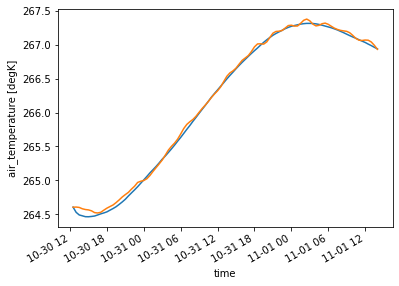

In [318]:
temp_free_da.air_temperature.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.air_temperature.isel(mid_levels=3, lat=20, lon=0).plot()

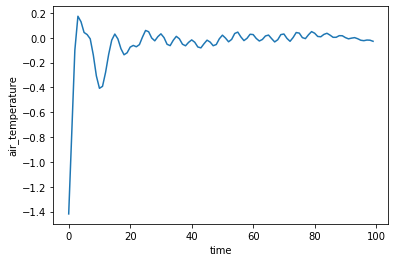

In [288]:
(diffs_da*1800).air_temperature.isel(mid_levels=3, lat=20, lon=0).plot()

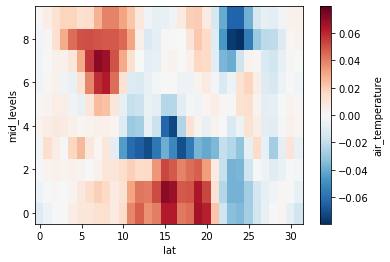

In [278]:
(diffs_da.air_temperature.isel(time=-2, lon=0)*1800).plot()

### Different time steps

In [319]:
free_model = MyModel(state=my_state)

In [320]:
forcer = ForcerNoWind()

In [321]:
1800/4

450.0

In [322]:
forced_model = MyModel(state=state3, extra_components=[forcer], 
                       dt_seconds=1800/4)

In [327]:
temp_free = []
temp_forced = []
diffs = []
free_model.state = my_state
forced_model.state = state3

In [331]:
factor = 1
tends = {}
for i in tqdm(range(20)):
    for v in input_vars[:-3]: # + ['air_pressure_on_interface_levels']:
        t = (
            (free_model.state[v] - forced_model.state[v]) /1800. / factor
        )
        if i >0: tends[v] = 0.3*tends[v] + 0.7*t
        else: tends[v] = t
        
    diffs.append(xr.Dataset(tends))
#     tends['air_pressure_on_interface_levels'] = tends['air_pressure_on_interface_levels'].rename({'interface_levels': 'mid_levels'})
    temp_free.append(xr.Dataset(free_model.state))
    temp_forced.append(xr.Dataset({k: v for k, v in forced_model.state.items() if k in list(free_model.state.keys())}))
    forcer.tends = {v: t.stack(geo=('lat', 'lon')).transpose('geo', 'mid_levels').values for v, t in tends.items()} 
    for _ in range(4): forced_model.step()
    free_model.step()

/home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/climt/_components/gfs/component.py:582: RuntimeWarning: invalid value encountered in less
  array[array < 0] = 0
/home/rasp/.conda/envs/stephan/lib/python3.7/site-packages/climt/_components/simple_physics/component.py:230: RuntimeWarning: invalid value encountered in less
  latent_heat_flux[latent_heat_flux < 0] = 0


In [329]:
temp_free_da = xr.concat(temp_free, 'time')
temp_forced_da = xr.concat(temp_forced, 'time', data_vars=list(free_model.state.keys()), fill_value=0)
diffs_da = xr.concat(diffs, 'time')

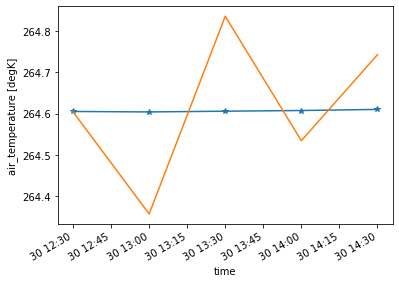

In [330]:
temp_free_da.air_temperature.isel(mid_levels=3, lat=20, lon=0).plot(marker='*')
temp_forced_da.air_temperature.isel(mid_levels=3, lat=20, lon=0).plot()

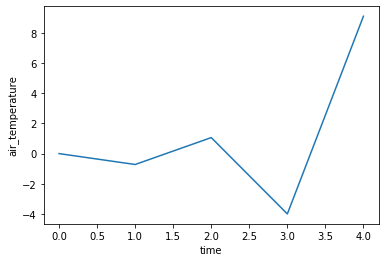

In [229]:
(diffs_da.air_temperature.isel(mid_levels=3, lat=20, lon=0) * 1800).plot()

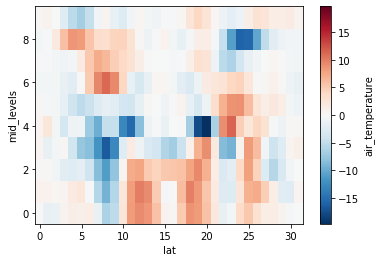

In [231]:
(diffs_da.air_temperature.isel(time=-1, lon=0)*1800).plot()

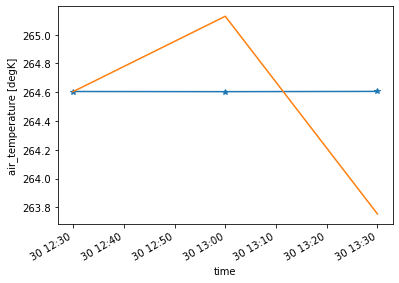

In [197]:
temp_free_da.air_temperature.isel(mid_levels=3, lat=20, lon=0).plot(marker='*')
temp_forced_da.air_temperature.isel(mid_levels=3, lat=20, lon=0).plot()

## Update

In [162]:
modified_convection = MyEmanuelConvection(
    entrainment_mixing_coefficient=1.5,   # Default 1.5
    convective_momentum_transfer_coefficient=0.3, # Default 0.7
    autoconversion_water_content_threshold=0.02, # Default 0.0011
    autoconversion_temperature_threshold=-30, # Default -55
    convection_bouyancy_threshold=0.9, # Default 0.9
    downdraft_area_fraction=0.001, # Default 0.05
    speed_snow=10, # Default 5.5
)

In [163]:
free_model = MyModel(state=my_state, convection=modified_convection)

In [164]:
forced_model = MyModel(state=state3, nophys=True)

In [171]:
temp_free = []
temp_forced = []
temp_forced2 = []
diffs = []
free_model.state = my_state
forced_model.state = state3

In [175]:
factor = 1
for i in tqdm(range(50)):
    tends = {}
    for v in input_vars[:-3]:
        tends[v] = (
            (free_model.state[v] - forced_model.state[v]) / factor
        )
        
    diffs.append(tends['air_temperature'])
    temp_free.append(free_model.state['air_temperature'])
    temp_forced.append(forced_model.state['air_temperature'])
#     forcer.tends = tends
    forced_model.step()
    free_model.step()
    temp_forced2.append(forced_model.state['air_temperature'])
    update = {}
    for v in input_vars[:-3]:
        update[v] = forced_model.state[v] + tends[v]
    forced_model.state.update(update)

In [176]:
temp_free_da = xr.concat(temp_free, 'time'); temp_free_da['time'] = temp_free_da['time']
temp_forced_da = xr.concat(temp_forced, 'time'); temp_forced_da['time'] = temp_forced_da['time']
temp_forced2_da = xr.concat(temp_forced2, 'time'); temp_forced2_da['time'] = temp_forced2_da['time'].values + 0.5
# diffs = xr.concat(diffs, 'time')

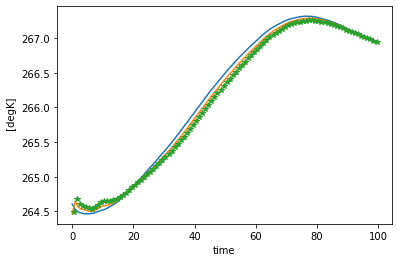

In [177]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced2_da.isel(mid_levels=3, lat=20, lon=0).plot(marker='*', linewidth=0)

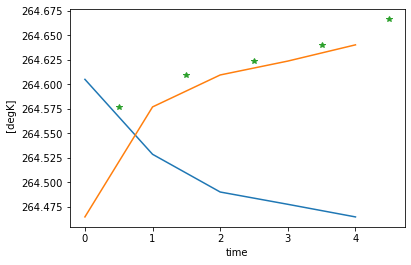

In [145]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced2_da.isel(mid_levels=3, lat=20, lon=0).plot(marker='*', linewidth=0)

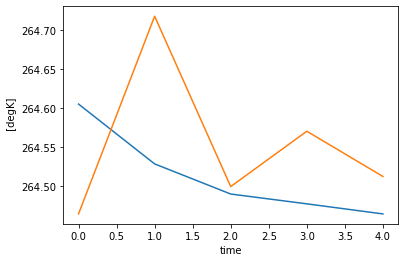

In [132]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()

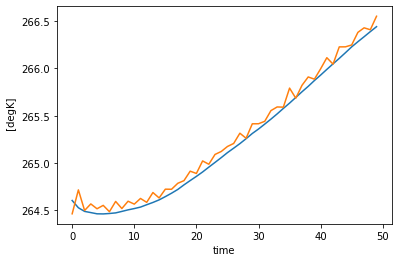

In [103]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()

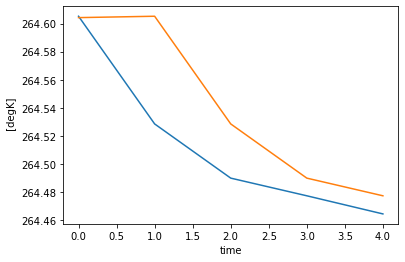

In [95]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()

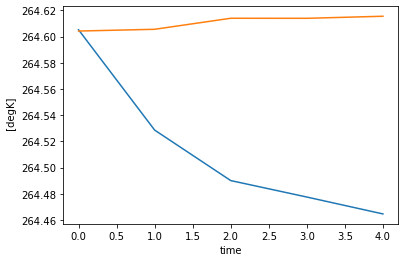

In [91]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()

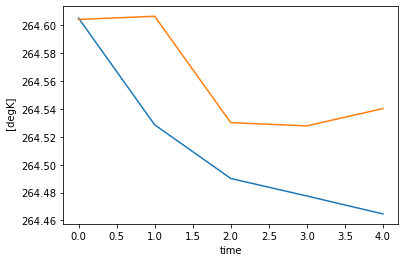

In [87]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()

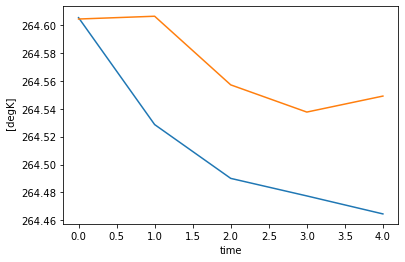

In [83]:
temp_free_da.isel(mid_levels=3, lat=20, lon=0).plot()
temp_forced_da.isel(mid_levels=3, lat=20, lon=0).plot()